In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from collections import Counter
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
)

import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available
    
print(device)

mps


In [3]:
# 1. Parameters
BATCH_SIZE = 64
EMBED_DIM = 128
HIDDEN_DIM = 128
EPOCHS = 20
MAX_VOCAB_SIZE = 25_000
MAX_SEQ_LEN = 256
DEVICE = device

RANDOM_SEED = 27
torch.manual_seed(RANDOM_SEED)

In [5]:
device

'mps'

In [53]:
# import os

# def load_imdb_data(data_dir, split):
#     """Loads IMDB reviews from disk. Returns list of (label, text) tuples."""
#     data = []
#     for label in ('pos', 'neg'):
#         labeled_dir = os.path.join(data_dir, split, label)
#         for fname in os.listdir(labeled_dir):
#             if fname.endswith('.txt'):
#                 with open(os.path.join(labeled_dir, fname), encoding='utf-8') as f:
#                     text = f.read()
#                     data.append((label, text))
#     return data

In [6]:
# Example usage:
# train_data = load_imdb_data('../../ML_Tinkering_Python/data/aclImdb', 'train')
# test_data = load_imdb_data('../../ML_Tinkering_Python/data/aclImdb', 'test')

train_data = '../../ML_Tinkering_Python/data/aclImdb/train/'
test_data = '../../ML_Tinkering_Python/data/aclImdb/test/'

In [ ]:
"""Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """

In [9]:
# Contains functionality for creating PyTorch DataLoaders for image classification data.

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str
    , test_dir: str
    , transform: transforms.Compose
    , batch_size: int
    , num_workers: int=NUM_WORKERS
):
  
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data
      , batch_size=batch_size
      , shuffle=True
      , num_workers=num_workers
      , pin_memory=True
  )
  test_dataloader = DataLoader(
      test_data
      , batch_size=batch_size
      , shuffle=False
      , num_workers=num_workers
      , pin_memory=True
  )

  return train_dataloader, test_dataloader, class_names

In [54]:
# 3. Build Vocabulary
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_list):
    for label, text in data_list:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(train_data),
    specials=["<unk>", "<pad>"],
    max_tokens=MAX_VOCAB_SIZE
)
vocab.set_default_index(vocab["<unk>"])

In [55]:
# 4. Text + Label Preprocessing
label_map = {"neg": 0, "pos": 1}

def process_text(text):
    tokens = tokenizer(text)
    token_ids = vocab(tokens)
    if len(token_ids) > MAX_SEQ_LEN:
        token_ids = token_ids[:MAX_SEQ_LEN]
    else:
        token_ids += [vocab["<pad>"]] * (MAX_SEQ_LEN - len(token_ids))
    return torch.tensor(token_ids, dtype=torch.long)

def process_label(label):
    return torch.tensor(label_map[label], dtype=torch.long)

In [56]:
# 5. Create PyTorch Dataset
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = []
        for label, text in samples:
            self.samples.append((process_text(text), process_label(label)))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

train_dataset = IMDBDataset(train_data)
test_dataset = IMDBDataset(test_data)

In [57]:
# 6. Handle Imbalanced Dataset (Weighted Loss)
labels = [label.item() for _, label in train_dataset]

class_counts = Counter(labels)

class_weights = [1.0 / class_counts[i] for i in range(len(class_counts))]

sample_weights = [class_weights[label] for label in labels]

sampler = WeightedRandomSampler(
    sample_weights
    , num_samples=len(sample_weights)
    , replacement=True
)

In [58]:
# 7. Create DataLoaders
train_loader = DataLoader(
    train_dataset
    , batch_size=BATCH_SIZE
    , sampler=sampler
    , num_workers=0  # <-- Fix: Use single process (avoid pickle issues)
)

test_loader = DataLoader(
    test_dataset
    , batch_size=BATCH_SIZE
    , shuffle=False
    , num_workers=0  # <-- Fix: Use single process (avoid pickle issues)
)

In [59]:
# 8. Define Model
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size
            , embed_dim
            , padding_idx=pad_idx
        )
        self.lstm = nn.LSTM(
            embed_dim
            , hidden_dim
            , batch_first=True
        )
        self.fc = nn.Linear(
            hidden_dim
            , num_classes
        )
    def forward(self, x):
        # x: (batch, seq_len)
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        # hidden: (1, batch, hidden_dim)
        out = self.fc(hidden[-1])
        return out

model = SimpleLSTM(
    vocab_size=len(vocab)
    , embed_dim=EMBED_DIM
    , hidden_dim=HIDDEN_DIM
    , num_classes=2
    , pad_idx=vocab["<pad>"]
).to(DEVICE)

In [60]:
# 9. Loss and Optimizer
# Use weighted cross entropy to deal with class imbalance

# weights
weights = torch.tensor(
    class_weights
    , dtype=torch.float
).to(DEVICE)

# criterion (CEL)
criterion = nn.CrossEntropyLoss(
    weight=weights)

# Optimizer (ADAM)

optimizer = optim.Adam(
    model.parameters(), lr=1e-3
    , weight_decay=1e-5 # added weight_decay to counteract overfitting (seen by decreasing test acc'y)
)

In [61]:
EPOCHS

20

In [62]:
# 10. Training Loop

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
        preds = output.argmax(dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_x.size(0)
    acc = correct / total
    print(f"Epoch {epoch+1}: Loss={total_loss/total:.4f}, Acc={acc:.4f}")

SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 1: Loss=0.6864, Acc=0.5312


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 2: Loss=0.6683, Acc=0.5610


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 3: Loss=0.6345, Acc=0.6301


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 4: Loss=0.6257, Acc=0.6218


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 5: Loss=0.6122, Acc=0.6308


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 6: Loss=0.5926, Acc=0.6302


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 7: Loss=0.5084, Acc=0.7492


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 8: Loss=0.5321, Acc=0.6581


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 9: Loss=0.4940, Acc=0.6998


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 10: Loss=0.4565, Acc=0.7550


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 11: Loss=0.3878, Acc=0.8318


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 12: Loss=0.3726, Acc=0.8410


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 13: Loss=0.3661, Acc=0.8431


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 14: Loss=0.3492, Acc=0.8545


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 15: Loss=0.4691, Acc=0.7462


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 16: Loss=0.3096, Acc=0.8673


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 17: Loss=0.1480, Acc=0.9490


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 18: Loss=0.0891, Acc=0.9733


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 19: Loss=0.0655, Acc=0.9816


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 20: Loss=0.0441, Acc=0.9884


In [63]:
# 11. Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)
        output = model(batch_x)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=["neg", "pos"]))

SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

              precision    recall  f1-score   support

         neg       0.84      0.81      0.83     12500
         pos       0.82      0.84      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [67]:
# Initial confusion matrix:
confusion_matrix(all_labels, all_preds)

array([[10181,  2319],
       [ 1950, 10550]])

In [64]:
confusion_matrix(all_labels, all_preds)

array([[10181,  2319],
       [ 1950, 10550]])

In [65]:
(confusion_matrix(all_labels, all_preds)[0,0]/(confusion_matrix(all_labels, all_preds)[0,0]+confusion_matrix(all_labels, all_preds)[0,1])), (confusion_matrix(all_labels, all_preds)[0,1]/(confusion_matrix(all_labels, all_preds)[0,0]+confusion_matrix(all_labels, all_preds)[0,1]))

# print('\n')

(confusion_matrix(all_labels, all_preds)[1,0]/(confusion_matrix(all_labels, all_preds)[1,0]+confusion_matrix(all_labels, all_preds)[1,1])), (confusion_matrix(all_labels, all_preds)[1,1]/(confusion_matrix(all_labels, all_preds)[1,0]+confusion_matrix(all_labels, all_preds)[1,1]))

(0.81448, 0.18552)

(0.156, 0.844)

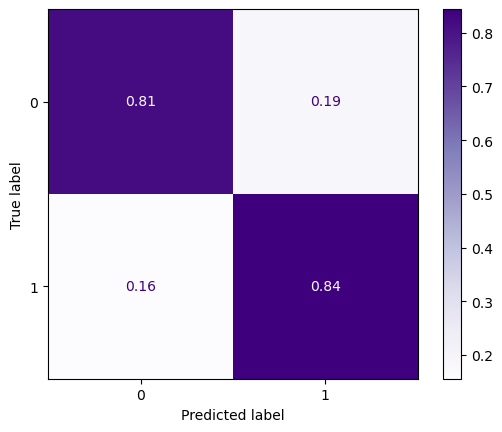

In [66]:
# Initial 
ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , normalize='true', cmap='Purples'
);

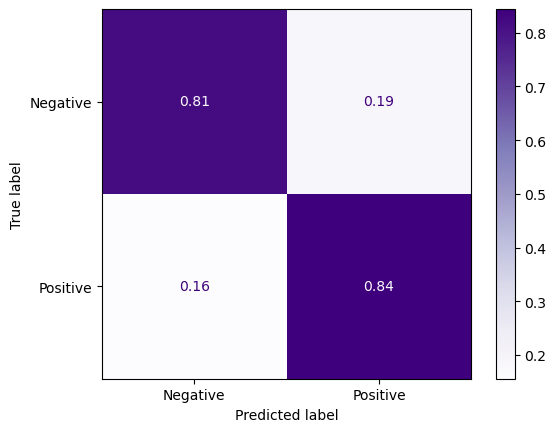

In [72]:
ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , normalize='true', cmap='Purples'
    , display_labels=["Negative", "Positive"]
);

In [68]:
# Function to retrain the model

# Trying a lower learning rate (lr) for retraining to counteract overfitting/ decreasing test acc'y; 
optimizer_r = optim.Adam(model.parameters(), lr=1e-4)

def retrain_model(model, train_loader, criterion, optimizer_r, device, epochs=10):
    """Retrains the model for a specified number of epochs."""
    print("Starting retraining...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_x.size(0)
            preds = output.argmax(dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_x.size(0)
        acc = correct / total
        print(f"Epoch {epoch + 1}: Loss={total_loss / total:.4f}, Acc={acc:.4f}")
    print("Retraining complete.")

In [69]:
# Function to reevaluate the model
def reevaluate_model(model, test_loader, device):
    """Evaluates the model on the test set and prints metrics."""
    print("Starting reevaluation...")
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_x)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # Print evaluation metrics
    print(classification_report(all_labels, all_preds, target_names=["neg", "pos"]))
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    ConfusionMatrixDisplay.from_predictions(
        all_labels, all_preds, normalize='true', cmap='Purples'
    )
    print("Reevaluation complete.")

In [70]:
# Example usage:
# Retrain for additional epochs
retrain_model(model, train_loader, criterion, optimizer, DEVICE, epochs=20)

Starting retraining...
Epoch 1: Loss=0.0339, Acc=0.9914
Epoch 2: Loss=0.0278, Acc=0.9930
Epoch 3: Loss=0.0222, Acc=0.9944
Epoch 4: Loss=0.0221, Acc=0.9940
Epoch 5: Loss=0.0237, Acc=0.9937
Epoch 6: Loss=0.0206, Acc=0.9944
Epoch 7: Loss=0.0226, Acc=0.9933
Epoch 8: Loss=0.0215, Acc=0.9939
Epoch 9: Loss=0.0158, Acc=0.9959
Epoch 10: Loss=0.0158, Acc=0.9959
Epoch 11: Loss=0.0159, Acc=0.9960
Epoch 12: Loss=0.0191, Acc=0.9947
Epoch 13: Loss=0.0126, Acc=0.9966
Epoch 14: Loss=0.0143, Acc=0.9965
Epoch 15: Loss=0.0123, Acc=0.9969
Epoch 16: Loss=0.0145, Acc=0.9960
Epoch 17: Loss=0.0099, Acc=0.9975
Epoch 18: Loss=0.0127, Acc=0.9968
Epoch 19: Loss=0.0131, Acc=0.9961
Epoch 20: Loss=0.0154, Acc=0.9959
Retraining complete.


Starting reevaluation...
              precision    recall  f1-score   support

         neg       0.80      0.87      0.84     12500
         pos       0.86      0.79      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

Confusion Matrix:
[[10906  1594]
 [ 2649  9851]]
Reevaluation complete.


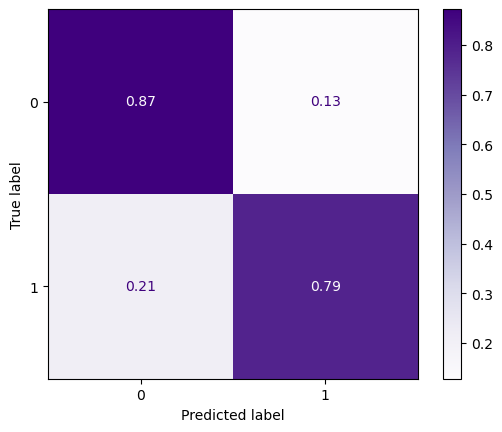

In [71]:
# Reevaluate the model on the test set
reevaluate_model(model, test_loader, DEVICE)

In [ ]:
# reevaluate_model(model, test_loader, DEVICE)
'''
init cm:
array([[10181,  2319],
       [ 1950, 10550]])

cm after retrain and reeval:
[[10906  1594]
 [ 2649  9851]]

'''